<a href="https://colab.research.google.com/github/MhamedBendenia/ArcGIS-COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
!pip install arcgis
!pip install geopandas
!pip install contextily==1.0rc2
!pip install pyunpack
!pip install patool
!apt-get -qq install python-cartopy python3-cartopy

!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 16599 (delta 0), reused 2 (delta 0), pack-reused 16593
Receiving objects: 100% (16599/16599), 64.81 MiB | 42.96 MiB/s, done.
Resolving deltas: 100% (8245/8245), done.


In [0]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import geopandas as gpd
import contextily as ctx
import requests
import cartopy

from pyunpack import Archive
from shapely.geometry import Point, Polygon , MultiPolygon
from arcgis import GIS
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
 

In [0]:
df_confirmed = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_deaths = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_recovred = pd.read_csv("./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [0]:
df_confirmed = df_confirmed.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})
df_deaths = df_deaths.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})
df_recovred = df_recovred.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"})

In [0]:
df_confirmed.Province_State.fillna(value=df_confirmed.Country_Region, inplace=True)
df_deaths.Province_State.fillna(value=df_deaths.Country_Region, inplace=True)
df_recovred.Province_State.fillna(value=df_recovred.Country_Region, inplace=True)
 
df_confirmed.Country_Region.replace({'East Timor': 'Timor-Leste', 'Syria': 'Syrian Arab Republic', 'Cabo Verde': 'Cape Verde', 'The Gambia': 'Gambia', 'Gambia, The': 'Gambia', 'Brunei': "Brunei Darussalam", 'Congo (Brazzaville)': "Democratic Republic of the Congo", 'Congo (Kinshasa)': "Democratic Republic of the Congo",
                                     'Czechia': "Czech Republic", 'Eswatini': "Swaziland", 'Holy See': 'Italy' , 'Iran': "Iran (Islamic Republic of)", 'Korea, South': "Korea, Republic of",
                                     'Kosovo': "Serbia", 'Moldova': "Republic of Moldova", 'North Macedonia': "The former Yugoslav Republic of Macedonia", 'Republic of the Congo': "Congo",
                                     'Taiwan*': "Taiwan", 'Tanzania': "United Republic of Tanzania", 'The Bahamas': "Bahamas", 'Bahamas, The': "Bahamas", 'US': "United States", 'Vietnam': "Viet Nam",
                                     'occupied Palestinian territory': "Palestine"}, inplace=True)

df_deaths.Country_Region.replace({'East Timor': 'Timor-Leste', 'Syria': 'Syrian Arab Republic', 'Cabo Verde': 'Cape Verde', 'The Gambia': 'Gambia', 'Gambia, The': 'Gambia', 'Brunei': "Brunei Darussalam", 'Congo (Brazzaville)': "Democratic Republic of the Congo", 'Congo (Kinshasa)': "Democratic Republic of the Congo",
                                     'Czechia': "Czech Republic", 'Eswatini': "Swaziland", 'Holy See': 'Italy' , 'Iran': "Iran (Islamic Republic of)", 'Korea, South': "Korea, Republic of",
                                     'Kosovo': "Serbia", 'Moldova': "Republic of Moldova", 'North Macedonia': "The former Yugoslav Republic of Macedonia", 'Republic of the Congo': "Congo",
                                     'Taiwan*': "Taiwan", 'Tanzania': "United Republic of Tanzania", 'The Bahamas': "Bahamas", 'Bahamas, The': "Bahamas", 'US': "United States", 'Vietnam': "Viet Nam",
                                     'occupied Palestinian territory': "Palestine"}, inplace=True)

df_recovred.Country_Region.replace({'East Timor': 'Timor-Leste', 'Syria': 'Syrian Arab Republic', 'Cabo Verde': 'Cape Verde', 'The Gambia': 'Gambia', 'Gambia, The': 'Gambia', 'Brunei': "Brunei Darussalam", 'Congo (Brazzaville)': "Democratic Republic of the Congo", 'Congo (Kinshasa)': "Democratic Republic of the Congo",
                                     'Czechia': "Czech Republic", 'Eswatini': "Swaziland", 'Holy See': 'Italy' , 'Iran': "Iran (Islamic Republic of)", 'Korea, South': "Korea, Republic of",
                                     'Kosovo': "Serbia", 'Moldova': "Republic of Moldova", 'North Macedonia': "The former Yugoslav Republic of Macedonia", 'Republic of the Congo': "Congo",
                                     'Taiwan*': "Taiwan", 'Tanzania': "United Republic of Tanzania", 'The Bahamas': "Bahamas", 'Bahamas, The': "Bahamas", 'US': "United States", 'Vietnam': "Viet Nam",
                                     'occupied Palestinian territory': "Palestine"}, inplace=True)

In [0]:
df_confirmed = df_confirmed.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()
df_deaths = df_deaths.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()
df_recovred = df_recovred.groupby(["Province_State",	"Country_Region", "Lat",	"Long"]).sum().stack().to_frame()

In [0]:
df_confirmed.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]
df_deaths.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]
df_recovred.index.names = ["Province_State",	"Country_Region", "Lat",	"Long", "Date"]

In [0]:
df_cases = df_confirmed.merge(df_deaths, on=["Province_State",	"Country_Region", "Lat",	"Long", "Date"])
df_cases = df_cases.merge(df_recovred, on=["Province_State",	"Country_Region", "Lat",	"Long", "Date"])
df_cases.columns = ["Confirmed", "Deaths", "Recovred"]

In [0]:
df_cases.reset_index(inplace= True)
df_cases["Date"] = df_cases['Date'].astype('datetime64[ns]')
gdf_cases = gpd.GeoDataFrame(df_cases, geometry=gpd.points_from_xy(df_cases.Long, df_cases.Lat), crs="epsg:4326")
gdf_cases.Date = gdf_cases.Date.apply(lambda t: str(t)[0:11])
gdf_cases.to_file('./covid_cases')

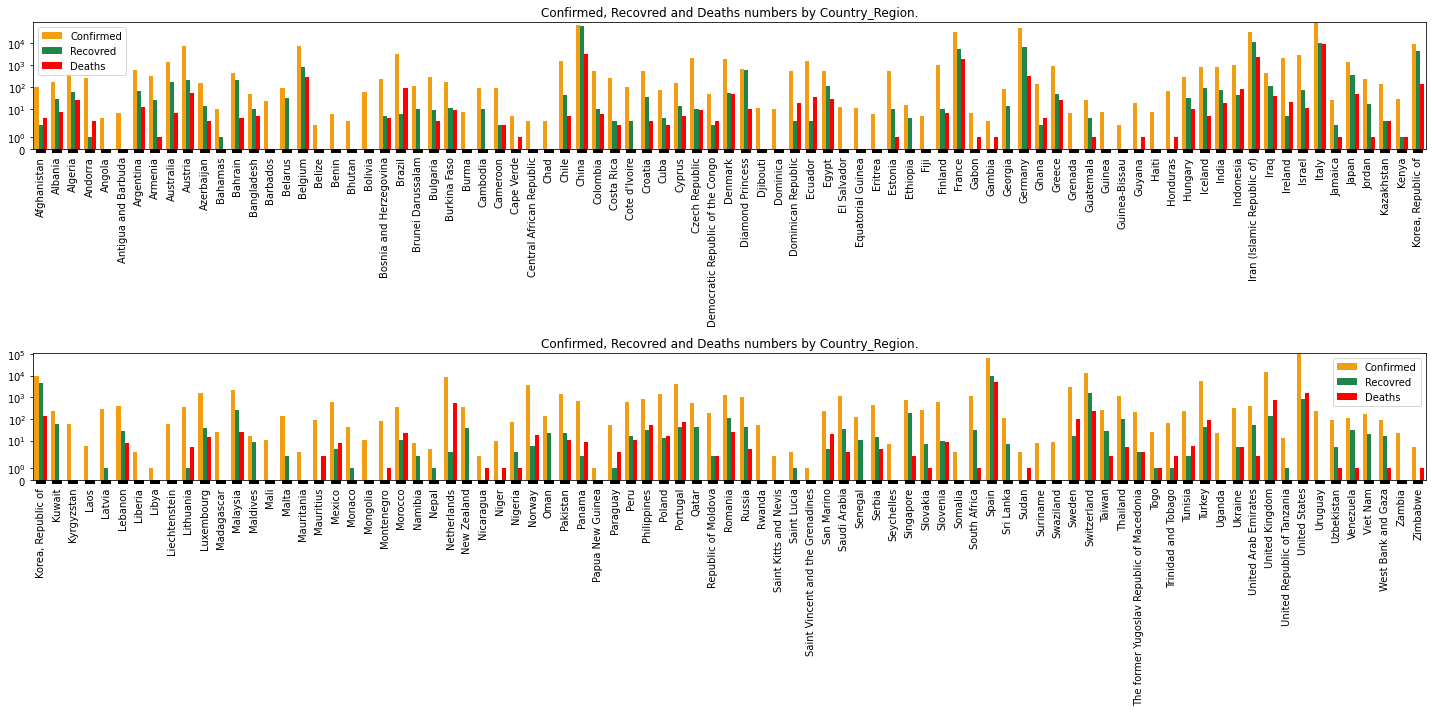

In [202]:
# graph plots
df_temp = df_cases.groupby("Country_Region")["Confirmed", "Deaths", "Recovred"].max().reset_index()
df_temp.drop(df_temp[(df_temp.Confirmed == 0) & (df_temp.Recovred == 0) & (df_temp.Deaths == 0)].index, inplace=True)

n = math.ceil(df_temp.Country_Region.count() / 2)

ind = np.arange(df_temp.Country_Region.count())[:n]   # the x locations for the groups

f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,10))

p1 = ax1.bar(ind-0.25, df_temp.Confirmed.head(n), 0.25 ,color=(0.95, 0.62, 0.07, 1))
p2 = ax1.bar(ind, df_temp.Recovred.head(n), 0.25, color=(0.12, 0.52, 0.29, 1))
p3 = ax1.bar(ind+0.25, df_temp.Deaths.head(n), 0.25, color=(1, 0, 0, 1))

plt.sca(ax1)
ax1.set_title('Confirmed, Recovred and Deaths numbers by Country_Region.')
plt.xticks(ind, df_temp.Country_Region.head(n), rotation=90)
ax1.set_yscale('symlog')
ax1.legend((p1[0], p2[0], p3[0]), ('Confirmed', 'Recovred', 'Deaths'))
ax1.margins(x=0.001)
plt.tick_params(axis="x", width=10)
plt.tight_layout()

p1 = ax2.bar(ind-0.25, df_temp.Confirmed.tail(n), 0.25 ,color=(0.95, 0.62, 0.07, 1))
p2 = ax2.bar(ind, df_temp.Recovred.tail(n), 0.25, color=(0.12, 0.52, 0.29, 1))
p3 = ax2.bar(ind+0.25, df_temp.Deaths.tail(n), 0.25, color=(1, 0, 0, 1))

plt.sca(ax2)
ax2.set_title('Confirmed, Recovred and Deaths numbers by Country_Region.')
plt.xticks(ind, df_temp.Country_Region.tail(n), rotation=90)
ax2.set_yscale('symlog')
ax2.legend((p1[0], p2[0], p3[0]), ('Confirmed', 'Recovred', 'Deaths'))
ax2.margins(x=0.001)
plt.tick_params(axis="x", width=10)
plt.tight_layout()

plt.show()

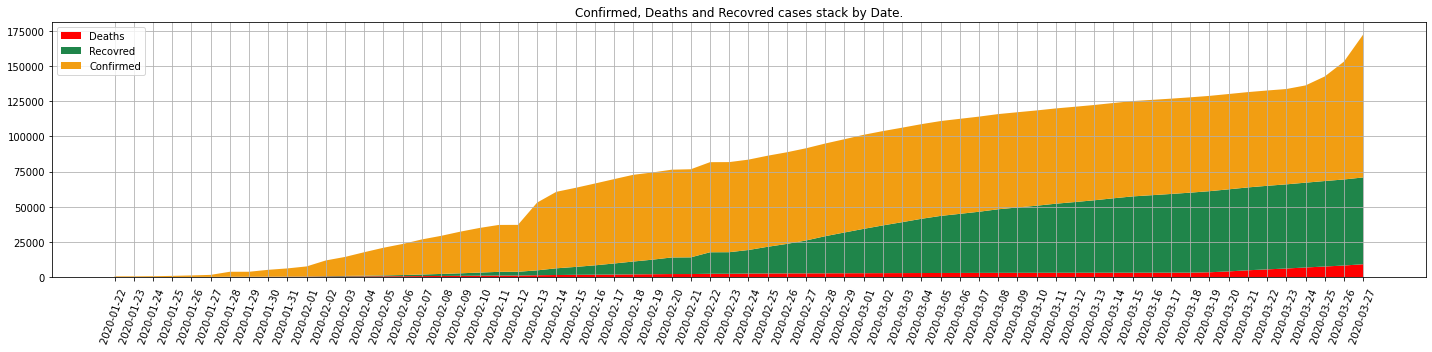

In [203]:
# stackplot
#All the world
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

#Only one country.
# df_temp = df_cases[df_cases.Country_Region == "Algeria"].groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()
# df_temp.drop(df_temp[(df_temp.Confirmed == 0) & (df_temp.Recovred == 0) & (df_temp.Deaths == 0)].index, inplace=True)

fig, ax = plt.subplots(figsize=(20,5))
plt.grid()
ax.stackplot(df_temp.Date.values, df_temp.Deaths.values, df_temp.Recovred.values, df_temp.Confirmed.values, labels=["Deaths", "Recovred", "Confirmed"], colors=[(1, 0, 0, 1), (0.12, 0.52, 0.29, 1), (0.95, 0.62, 0.07, 1)])
ax.legend(loc=2)
plt.title("Confirmed, Deaths and Recovred cases stack by Date.")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

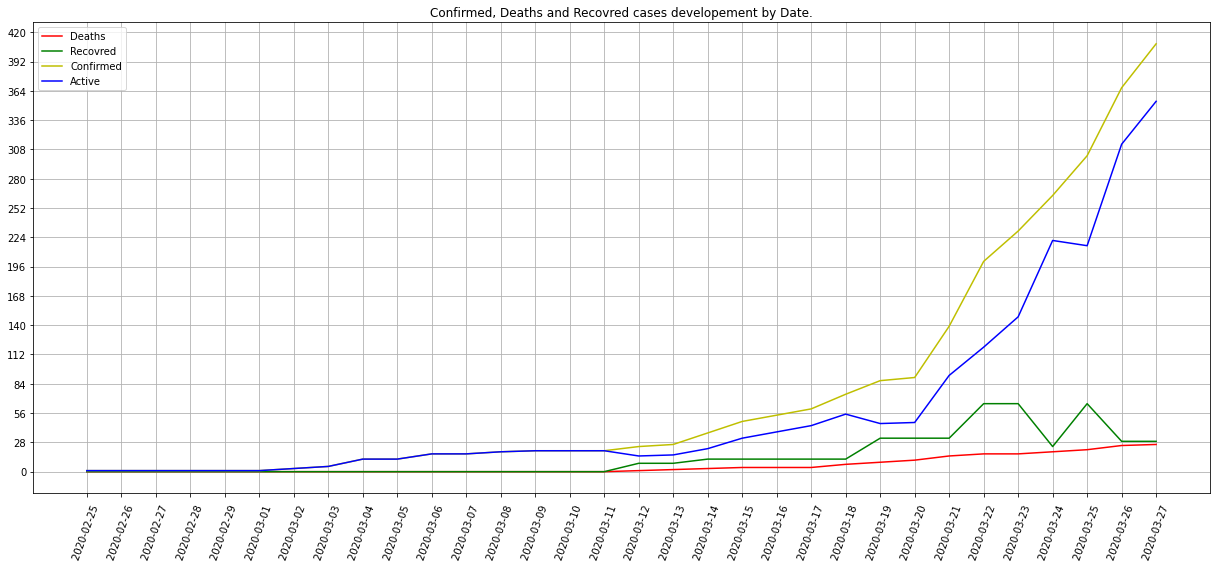

In [204]:
# lineplot
#All the world
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

# #Only one country.
# df_temp = df_cases[df_cases.Country_Region == "Algeria"].groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()
# df_temp.drop(df_temp[(df_temp.Confirmed == 0) & (df_temp.Recovred == 0) & (df_temp.Deaths == 0)].index, inplace=True)

#Agregate Date
# df_temp['Date'] = pd.to_datetime(df_temp['Date'])
# df_temp = df_temp.groupby(pd.Grouper(key='Date', freq='3d'))["Confirmed", "Deaths", "Recovred"].max().reset_index()

fig, ax = plt.subplots(figsize=(17,8))

plt.grid()
ax.plot(df_temp.Date, df_temp.Deaths, 'r', label="Deaths")
ax.plot(df_temp.Date, df_temp.Recovred, 'g', label="Recovred")
ax.plot(df_temp.Date, df_temp.Confirmed, 'y', label="Confirmed")
ax.plot(df_temp.Date, df_temp.Confirmed - (df_temp.Recovred + df_temp.Deaths), 'b', label="Active")

ax.legend(loc=2)
plt.title("Confirmed, Deaths and Recovred cases developement by Date.")
plt.xticks(rotation=70, ticks= df_temp.Date )
plt.yticks(np.arange(0, df_temp.Confirmed.max() + df_temp.Confirmed.max() / 15, math.ceil(df_temp.Confirmed.max() / 15)))
plt.tight_layout()
plt.savefig("Algeria.png")
plt.show()

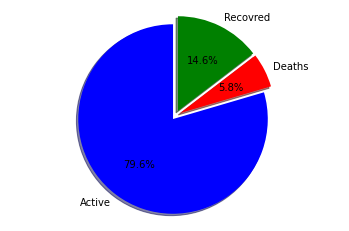

In [205]:
# Pie chart
Active = (df_temp.Confirmed.values - (df_temp.Recovred.values + df_temp.Deaths.values)).max()
Deaths = df_temp.Deaths.values.max()
Recovred = df_temp.Recovred.values.max()

labels = 'Active', 'Deaths', 'Recovred'
sizes = [ Active, Deaths, Recovred]
explode = (0.05, 0.05, 0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=["blue", "red", "green"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

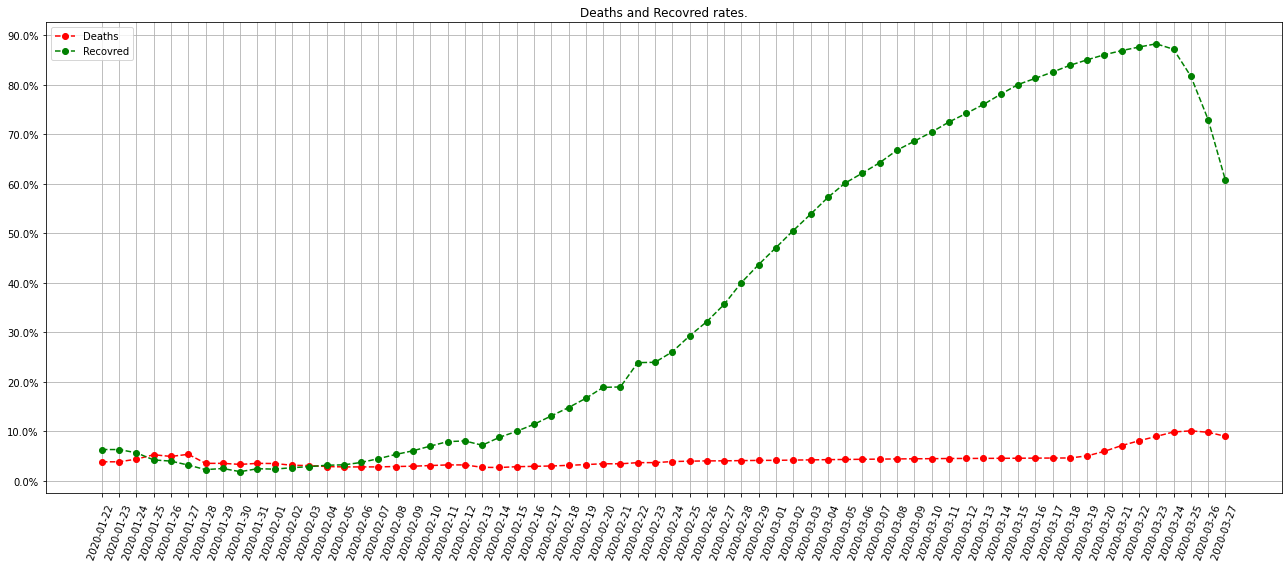

In [206]:
# lineplot
df_temp = df_cases.groupby("Date")["Confirmed", "Deaths", "Recovred"].max().reset_index()

fig, ax = plt.subplots(figsize=(18,8))

plt.grid()
ax.plot(df_temp.Date.values, df_temp.Deaths.values / df_temp.Confirmed.values, 'r--', marker="o", label="Deaths")
ax.plot(df_temp.Date.values, df_temp.Recovred.values / df_temp.Confirmed.values, 'g--', marker="o", label="Recovred")

ax.legend(loc=2)
plt.title("Deaths and Recovred rates.")
plt.xticks(rotation=70)
plt.yticks(np.arange(0, 1, 0.10))
ax.set_yticklabels(['{:.1f}%'.format(x*100) for x in ax.get_yticks()])
plt.tight_layout()
plt.show()

In [207]:
!wget https://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
%mkdir world
Archive('./TM_WORLD_BORDERS-0.3.zip').extractall('./world')

--2020-03-28 13:54:09--  https://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip
Resolving thematicmapping.org (thematicmapping.org)... 67.20.120.230
Connecting to thematicmapping.org (thematicmapping.org)|67.20.120.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3464707 (3.3M) [application/zip]
Saving to: ‘TM_WORLD_BORDERS-0.3.zip’

TM_WORLD_BORDERS-0. 100%[===================>]   3.30M  13.3MB/s    in 0.2s    

2020-03-28 13:54:10 (13.3 MB/s) - ‘TM_WORLD_BORDERS-0.3.zip’ saved [3464707/3464707]



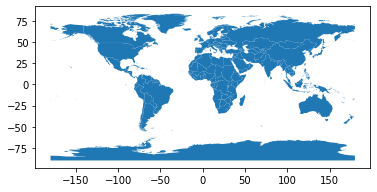

In [208]:
world_shp = gpd.read_file("./world/TM_WORLD_BORDERS-0.3.shp")
world_shp.columns = ['FIPS', 'ISO2', 'ISO3', 'UN', 'Country_Region', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry']
world_shp.drop(['ISO2', 'ISO3', 'UN', 'AREA', 'POP2005', 'REGION', 'SUBREGION', 'LON', 'LAT'], axis=1, inplace=True)
world_shp.plot()

In [0]:
date_world_cases = world_shp.merge(gdf_cases, on='Country_Region', suffixes=("", "_point"), how='right')

date_world_cases.drop(labels=["Province_State",	"Lat",	"Long", "geometry_point"], axis=1, inplace=True)
date_world_cases.drop(date_world_cases[(date_world_cases.Confirmed == 0) & (date_world_cases.Recovred == 0) & (date_world_cases.Deaths == 0)].index, inplace=True)

date_world_cases.sort_values(by=["Date", "Confirmed",	"Deaths",	"Recovred"], inplace=True)
date_world_cases.drop_duplicates(subset=["Country_Region", "Date"], inplace=True, keep='last')

date_world_cases.to_file("./date_world_cases")

In [0]:
world_cases = world_shp.merge(gdf_cases, on='Country_Region', suffixes=("", "_point"), how='outer')

world_cases.drop(labels=["Province_State",	"Lat",	"Long", "geometry_point"], axis=1, inplace=True)

world_cases.sort_values(by=["Date", "Confirmed",	"Deaths",	"Recovred"], inplace=True)
world_cases.drop_duplicates(subset=["Country_Region", "Date"], inplace=True, keep='last')

world_cases = world_cases.groupby(["Country_Region"])["geometry","Confirmed", "Deaths", "Recovred"].last()
world_cases.reset_index(inplace=True)

g=gpd.GeoDataFrame(world_cases)
g.to_file("./world_cases")

In [211]:
!zip -r COVID-19.zip date_world_cases world_cases covid_cases
!find . \! -name 'COVID-19.zip' -delete

updating: date_world_cases/ (stored 0%)
updating: date_world_cases/date_world_cases.prj (deflated 15%)
updating: date_world_cases/date_world_cases.cpg (stored 0%)
updating: date_world_cases/date_world_cases.shp (deflated 45%)
updating: date_world_cases/date_world_cases.shx (deflated 36%)
updating: date_world_cases/date_world_cases.dbf (deflated 95%)
updating: world_cases/ (stored 0%)
updating: world_cases/world_cases.shx (deflated 24%)
updating: world_cases/world_cases.cpg (stored 0%)
updating: world_cases/world_cases.dbf (deflated 91%)
updating: world_cases/world_cases.shp (deflated 45%)
updating: covid_cases/ (stored 0%)
updating: covid_cases/covid_cases.cpg (stored 0%)
updating: covid_cases/covid_cases.prj (deflated 15%)
updating: covid_cases/covid_cases.shp (deflated 92%)
updating: covid_cases/covid_cases.dbf (deflated 98%)
updating: covid_cases/covid_cases.shx (deflated 71%)


In [212]:
"""Values to correct(Cruise Ship has None geometry)"""
world_cases[world_cases.geometry == None].groupby("Country_Region").last()

,geometry,Confirmed,Deaths,Recovred
Country_Region,,,,
Diamond Princess,None,712.0,10.0,597.0
Laos,None,6.0,0.0,0.0
Libya,None,1.0,0.0,0.0
West Bank and Gaza,None,91.0,1.0,17.0


In [213]:
!wget ftp://ftp.ncdc.noaa.gov/pub/data/gsod/2020/gsod_2020.tar
!wget ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt

%mkdir ./gsod_2020
!tar -xvf gsod_2020.tar -C "./gsod_2020"
!gunzip -v ./gsod_2020/*.gz

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
./gsod_2020/714810-99999-2020.op.gz:	 84.1% -- replaced with ./gsod_2020/714810-99999-2020.op
./gsod_2020/714820-99999-2020.op.gz:	 82.7% -- replaced with ./gsod_2020/714820-99999-2020.op
./gsod_2020/714830-99999-2020.op.gz:	 84.2% -- replaced with ./gsod_2020/714830-99999-2020.op
./gsod_2020/714840-99999-2020.op.gz:	 78.4% -- replaced with ./gsod_2020/714840-99999-2020.op
./gsod_2020/714850-99999-2020.op.gz:	 79.1% -- replaced with ./gsod_2020/714850-99999-2020.op
./gsod_2020/714860-99999-2020.op.gz:	 78.4% -- replaced with ./gsod_2020/714860-99999-2020.op
./gsod_2020/714870-99999-2020.op.gz:	 78.7% -- replaced with ./gsod_2020/714870-99999-2020.op
./gsod_2020/714880-99999-2020.op.gz:	 77.2% -- replaced with ./gsod_2020/714880-99999-2020.op
./gsod_2020/714890-99999-2020.op.gz:	 79.1% -- replaced with ./gsod_2020/714890-99999-2020.op
./gsod_2020/714900-99999-2020.op.gz:	 78.0% -- replaced with ./gsod_2020/714

In [0]:
countries_stations = pd.read_fwf('isd-history.txt', colspecs=[(0, 6), (43, 45)],
                                 names=["USAF", "FIPS"]).iloc[22:]

countries_stations.dropna(inplace=True)

In [0]:
for file in os.listdir("./gsod_2020/"):
  t=countries_stations[file[:6] == countries_stations['USAF']].FIPS
  if len(t) == 0:
    continue
  os.rename(r'./gsod_2020/'+file, r'./gsod_2020/'+t.values[0])

In [294]:
weather_data = pd.DataFrame()
for index, row in date_world_cases.iterrows():
  if pd.isna(row.FIPS) or not os.path.exists("./gsod_2020/" + row.FIPS): continue
  temp = pd.read_fwf("./gsod_2020/" + row.FIPS, colspecs=[(14, 18), (18, 20), (20, 22), (24, 30), (35, 41), (46, 52), (57, 63), (68, 73), (78, 83), (88, 93), (95, 100), (102, 108), (110, 116), (118, 123), (125, 130)], 
                     names=["Year", "month", "Day", "Temp", "Dewp", "Slp", "Stp", "Visib", "Wdsp", "Mxspd", "Gust", "MaxTemp", "MinTemp", "Prcp", "Sndp"]).iloc[1:]
  temp['Date'] = temp[["Year", "month", "Day"]].apply(lambda x: '-'.join(x), axis=1)
  temp['FIPS'] = row.FIPS
  temp.drop(["Year", "month", "Day"], axis=1, inplace=True)
  weather_data = weather_data.append(temp)

date_world_cases.Date = date_world_cases.Date.apply(lambda t: str(t)[0:10])

weather_data.drop_duplicates(inplace=True)

world_weather = date_world_cases.merge(weather_data, on=["Date", "FIPS"], how='inner')
world_weather = world_weather.astype({"Temp": float, "Dewp": float, "Slp": float, "Stp": float, "Visib": float, "Wdsp": float,
                                      "Mxspd": float, "Gust": float,"MaxTemp": float, "MinTemp": float, "Prcp": float, "Sndp": float})

world_weather.to_file("./world_weather")
!zip -r WEATHER-COVID-19.zip world_weather

  adding: world_weather/ (stored 0%)
  adding: world_weather/world_weather.dbf (deflated 94%)
  adding: world_weather/world_weather.shx (deflated 59%)
  adding: world_weather/world_weather.cpg (stored 0%)
  adding: world_weather/world_weather.shp (deflated 56%)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


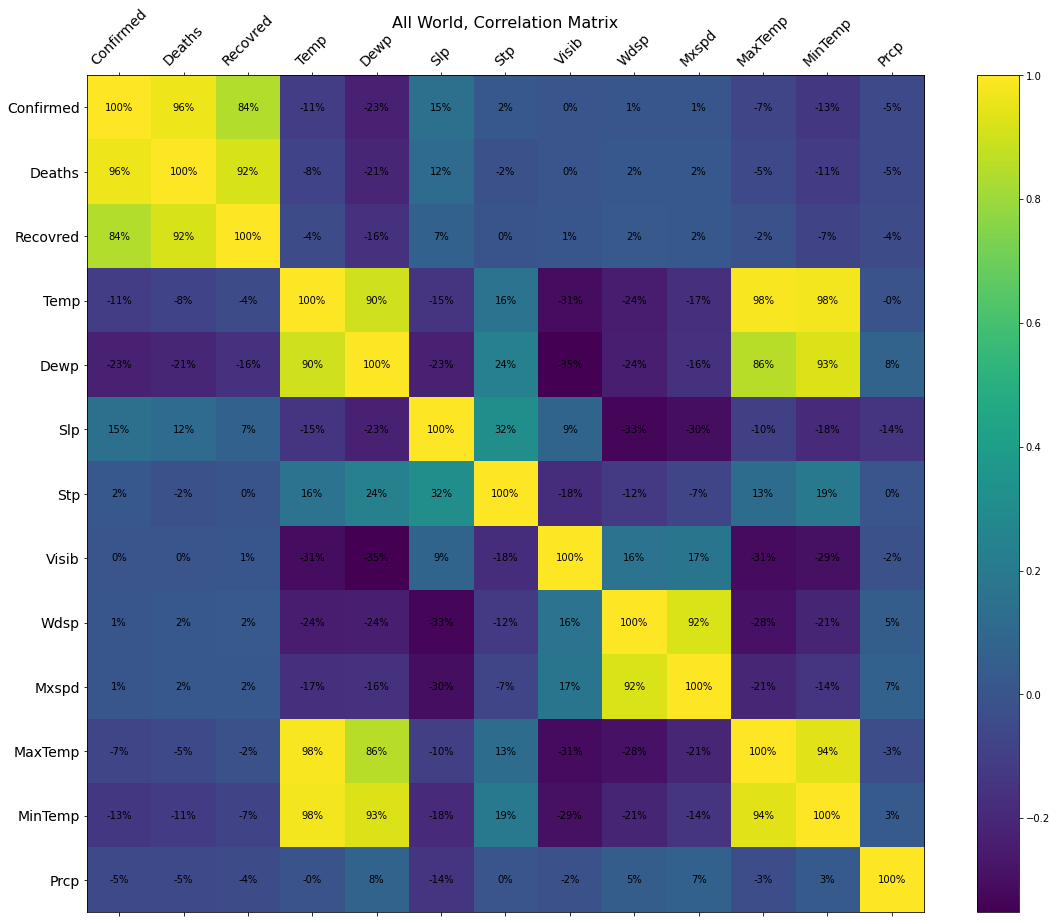

In [217]:
world_weather.drop(["Country_Region", "geometry", "Confirmed", "Deaths", "Recovred", "Gust",	"Sndp"], axis=1, inplace=True)
world_weather.replace(to_replace=[9999.9, 999.9, 99.99], value=pd.np.nan, inplace=True)
date_world_cases = date_world_cases.sort_values(["FIPS", "Date"]).reset_index().drop(["index"], axis=1)

for index, row in date_world_cases.iterrows():
  if index == 0 or (row.FIPS is not date_world_cases[date_world_cases.index == index - 1].FIPS.values[0]): continue
  date_world_cases.Confirmed.__setitem__(index, [0 if date_world_cases.Confirmed.get(index) - date_world_cases.Confirmed.get(index -1) < 0 else date_world_cases.Confirmed.get(index) - date_world_cases.Confirmed.get(index -1)][0]) 
  date_world_cases.Deaths.__setitem__(index, [0 if date_world_cases.Deaths.get(index) - date_world_cases.Deaths.get(index -1) < 0 else date_world_cases.Deaths.get(index) - date_world_cases.Deaths.get(index -1)][0]) 
  date_world_cases.Recovred.__setitem__(index, [0 if date_world_cases.Recovred.get(index) - date_world_cases.Recovred.get(index -1) < 0 else date_world_cases.Recovred.get(index) - date_world_cases.Recovred.get(index -1)][0]) 

df_temp = date_world_cases.merge(world_weather, on=["Date", "FIPS"], how='inner')

df_temp = df_temp.drop(["Country_Region", "geometry", "Date", "FIPS"], axis=1) #.set_index("Country_Region")
df_temp.drop_duplicates(inplace=True)
df_temp.dropna(inplace=True)

corr = df_temp.corr()
corr
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(df_temp.shape[1]), df_temp.columns, fontsize=14, rotation=45)
plt.yticks(range(df_temp.shape[1]), df_temp.columns, fontsize=14)
plt.colorbar()
ax.tick_params(labelsize=14)

for i in range(len(corr.columns)):
    for j in range(len(corr.index)):
        text = plt.text(j, i, "{0:.0f}%".format(corr.iloc[i, j]*100), ha="center", va="center", color="black")
        
plt.title( 'All World, Correlation Matrix', fontsize=16);
plt.show()

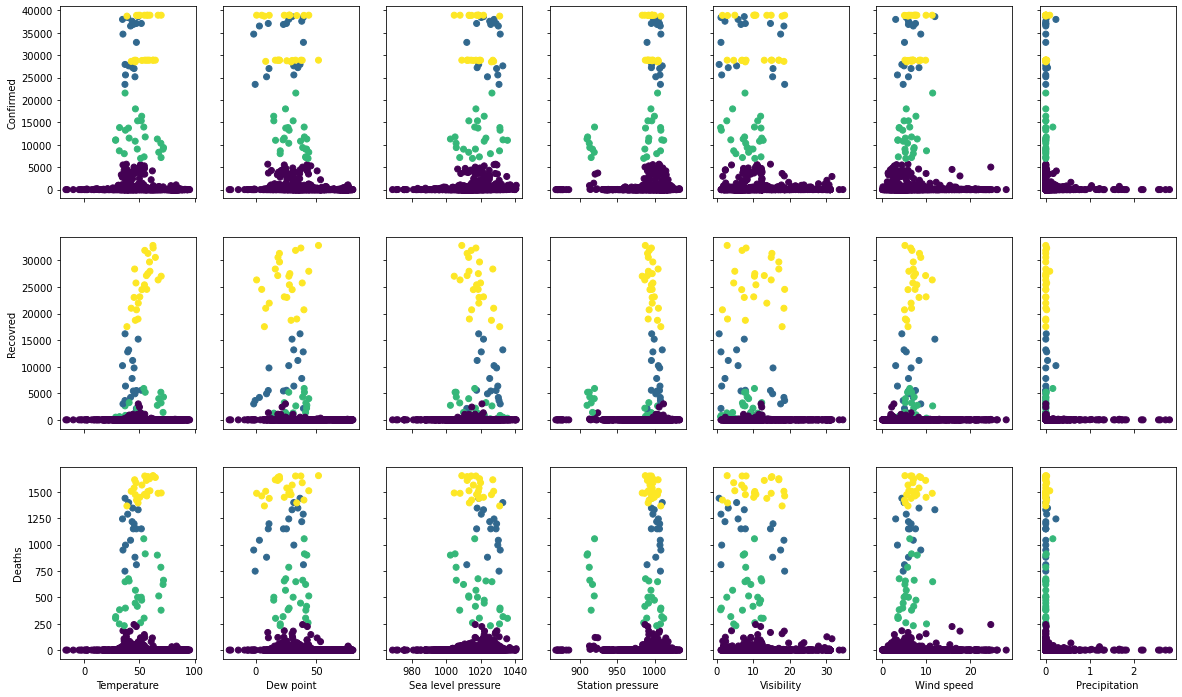

In [293]:
from sklearn.cluster import KMeans

df_temp = date_world_cases.merge(world_weather, on=["Date", "FIPS"], how='inner')

df_temp = df_temp.drop(["Country_Region", "geometry", "Date", "FIPS"], axis=1)
df_temp.drop_duplicates(inplace=True)
df_temp.dropna(inplace=True)

fig , axes = plt.subplots(nrows=3, ncols=7, sharex='col', sharey='row', figsize=(20, 12))

y_pred = KMeans(n_clusters=4).fit_predict(df_temp)

axes[0,0].scatter(df_temp.Temp, df_temp.Confirmed, c=y_pred)
axes[0,1].scatter(df_temp.Dewp, df_temp.Confirmed, c=y_pred)
axes[0,2].scatter(df_temp.Slp, df_temp.Confirmed, c=y_pred)
axes[0,3].scatter(df_temp.Stp, df_temp.Confirmed, c=y_pred)
axes[0,4].scatter(df_temp.Visib, df_temp.Confirmed, c=y_pred)
axes[0,5].scatter(df_temp.Wdsp, df_temp.Confirmed, c=y_pred)
axes[0,6].scatter(df_temp.Prcp, df_temp.Confirmed, c=y_pred)

axes[1,0].scatter(df_temp.Temp, df_temp.Recovred, c=y_pred)
axes[1,1].scatter(df_temp.Dewp, df_temp.Recovred, c=y_pred)
axes[1,2].scatter(df_temp.Slp, df_temp.Recovred, c=y_pred)
axes[1,3].scatter(df_temp.Stp, df_temp.Recovred, c=y_pred)
axes[1,4].scatter(df_temp.Visib, df_temp.Recovred, c=y_pred)
axes[1,5].scatter(df_temp.Wdsp, df_temp.Recovred, c=y_pred)
axes[1,6].scatter(df_temp.Prcp, df_temp.Recovred, c=y_pred)

axes[2,0].scatter(df_temp.Temp, df_temp.Deaths, c=y_pred)
axes[2,1].scatter(df_temp.Dewp, df_temp.Deaths, c=y_pred)
axes[2,2].scatter(df_temp.Slp, df_temp.Deaths, c=y_pred)
axes[2,3].scatter(df_temp.Stp, df_temp.Deaths, c=y_pred)
axes[2,4].scatter(df_temp.Visib, df_temp.Deaths, c=y_pred)
axes[2,5].scatter(df_temp.Wdsp, df_temp.Deaths, c=y_pred)
axes[2,6].scatter(df_temp.Prcp, df_temp.Deaths, c=y_pred)

axes[0,0].set_ylabel('Confirmed')
axes[1,0].set_ylabel('Recovred')
axes[2,0].set_ylabel('Deaths')

axes[2,0].set_xlabel('Temperature')
axes[2,1].set_xlabel('Dew point')
axes[2,2].set_xlabel('Sea level pressure')
axes[2,3].set_xlabel('Station pressure')
axes[2,4].set_xlabel('Visibility')
axes[2,5].set_xlabel('Wind speed')
axes[2,6].set_xlabel('Precipitation')

plt.show()

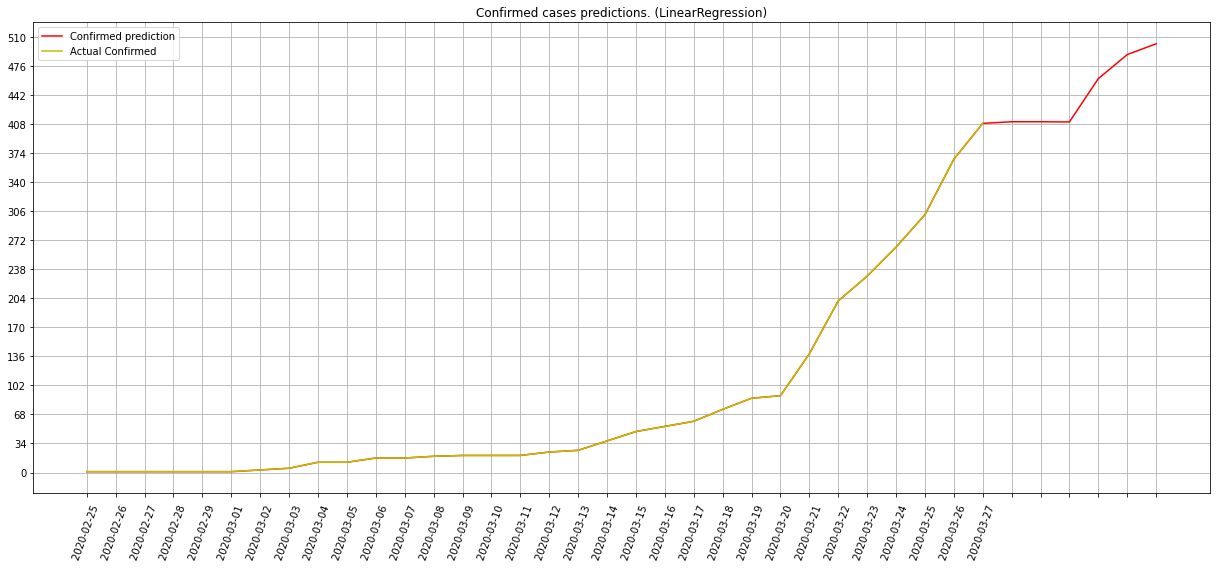

In [257]:
# example of training a final regression model
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
# generate regression dataset

df_temp = df_cases[df_cases.Country_Region == "Algeria"].drop(labels=["Province_State",	"Lat",	"Long",	"geometry"], axis=1)
df_temp.drop(df_temp[(df_temp.Confirmed == 0) & (df_temp.Recovred == 0) & (df_temp.Deaths == 0)].index, inplace=True)

X, y = df_cases.drop(labels=["Lat",	"Long",	"geometry", "Province_State",	"Country_Region", "Confirmed",	'Date'], axis=1), df_cases.Confirmed
# fit final model
model = LinearRegression()
model.fit(X, y)
prediction = model.predict(df_temp.drop(labels=['Country_Region', "Confirmed",	'Date'], axis=1))
prediction = df_temp.Confirmed.append(pd.Series(prediction[prediction > df_temp.Confirmed.max()]), ignore_index=True)

fig, ax = plt.subplots(figsize=(17,8))

plt.grid()
ax.plot(np.arange(len(prediction)), prediction, 'r', label="Confirmed prediction")
ax.plot(np.arange(len(df_temp.Confirmed)), df_temp.Confirmed, 'y', label="Actual Confirmed")

ax.legend(loc=2)
plt.title("Confirmed cases predictions. (LinearRegression)")
plt.xticks(np.arange(len(prediction)), labels=df_temp.Date, rotation=70)
plt.yticks(np.arange(0, prediction.max() + prediction.max() / 15, math.ceil(prediction.max() / 15)))
plt.tight_layout()
plt.savefig("Algeria.png")
plt.show()